In [1]:
import pickle
import glob
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = r'C:\Windows\Fonts\gulim.ttc'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
steady_ga_paths = glob.glob("../none_hybrid/pickle_data/*")
hybrid_ga_paths = glob.glob("./pickle_data/Hybrid*")

In [2]:
with open('./pickle_data/Hybrid_GA_cluster21111.pkl', 'rb') as f:
    result = pickle.load(f)

In [4]:
steady_ga_container = []
for path in steady_ga_paths:
    with open(path, 'rb') as f:
        steady_ga = pickle.load(f)
        steady_ga_container.append(steady_ga)

hybrid_ga_container = []
for path in hybrid_ga_paths:
    with open(path, 'rb') as f:
        hybrid_ga = pickle.load(f)
        hybrid_ga_container.append(hybrid_ga)

with open('./pickle_data/graph.pkl', 'rb') as f:
    graph = pickle.load(f)

In [5]:
# 변수 설정
time_set = dict()
time_set['start_time'] = 9
time_set['end_time'] = 18
time_set['load_rest_time'] = 0.3

shortest_path_dict = graph.get_shortest_path_dict()

In [6]:
def print_tp_block_num(transporter):
    for block in transporter.works:
        print(f'block_no: {block.no}, job: {block.start_node} -> {block.end_node}, limit_time: {block.start_time} -> {block.end_time}', end=' ')
    print()



In [7]:
def fitness(individual, time_set, shortest_path_dict):
    start_time = time_set['start_time']
    end_time = time_set['end_time']
    load_rest_time = time_set['load_rest_time']
    total_time = 0  # 모든 트랜스포터가 일을 마치는 시간을 계산
    DOCK = 1 # 트랜스포터 시작 노드
    result = dict()
    fitness_score = 0
    empty_tp_score = 1000

    for transporter in individual:
        result[transporter.no] = []
        cur_time = start_time  # 작업을 시작할 수 있는 가장 빠른 시간
        cur_node = DOCK  # 현재 위치는 도크

        if not transporter.works:
            fitness_score += empty_tp_score
            if transporter.available_weight > 500:
                fitness_score += empty_tp_score // 100

        for block in transporter.works:
            # 트랜스포터 위치 -> 블록 시작 위치
            dist = shortest_path_dict[cur_node][block.start_node] / 1000  # 이전 위치에서 현재 블록까지 이동한 거리
            cur_time += dist / transporter.empty_speed  # 이동 시간 추가

            # 블록 시작 위치 -> 블록 적재 위치
            cur_time = max(cur_time, block.start_time)  # 블록의 작업 시작 시간 이전에 도착한 경우, 해당 시간까지 대기
            job_start_time = round(cur_time, 3)
            cur_time += (shortest_path_dict[block.start_node][block.end_node] / 1000) / transporter.work_speed  # 블록을 운반하는데 걸리는 시간 추가
            job_end_time = round(cur_time, 3)

            flag = "X"
            if  block.start_time <= job_start_time and job_end_time <= block.end_time:
                flag = "O"
            result[transporter.no].append({
                'block': block.no,
                'pos': f'{block.start_node} -> {block.end_node}',
                'limit_time': f'{block.start_time} -> {block.end_time}',
                'process_time': f'{job_start_time} -> {job_end_time}',
                '시간을 지켰나요?': flag,
            })

            # 블록 적재
            cur_time += load_rest_time
            cur_node = block.end_node  # 현재 위치를 블록의 종료 위치로 업데이트



        total_time = max(total_time, cur_time)  # 모든 트랜스포터가 일을 마치는 시간 업데이트


    fitness_score += 1 / total_time * 1

    for transporter in individual:
        if any(work.weight > transporter.available_weight for work in transporter.works):
            fitness_score *= 0.5

    if total_time >= end_time:  # 전체 작업 완료 시간이 18시를 초과하면 해당 해는 유효하지 않음
        fitness_score *= 0.5

    return result  # 전체 작업 완료 시간의 역수를 반환하여 적합도 계산

In [8]:
def get_individual_distance(individual, shortest_path_dict):
    DOCK = 1 # 트랜스포터 시작 노드

    fitness_score = 0

    for transporter in individual:
        cur_node = DOCK  # 현재 위치는 도크

        for block in transporter.works:
            # 트랜스포터 위치 -> 블록 시작 위치
            load_to_block_dist = shortest_path_dict[cur_node][block.start_node] / 1000  # 이전 위치에서 현재 블록까지 이동한 거리
            # 블록 시작 위치 -> 블록 적재 위치
            block_delivery_dist = shortest_path_dict[block.start_node][block.end_node] / 1000
            fitness_score += load_to_block_dist + block_delivery_dist
            cur_node = block.end_node  # 현재 위치를 블록의 종료 위치로 업데이트


    return fitness_score

In [9]:
re = fitness(result['best_individual'], time_set, shortest_path_dict)

for key in re.keys():
    works = re[key]
    if re[key]:
        print(key)
        for block in re[key]:
            print(block)

0
{'block': 17, 'pos': '1 -> 6', 'limit_time': '9 -> 14', 'process_time': '9.0 -> 9.367', '시간을 지켰나요?': 'O'}
{'block': 70, 'pos': '3 -> 5', 'limit_time': '13 -> 17', 'process_time': '13 -> 13.233', '시간을 지켰나요?': 'O'}
{'block': 159, 'pos': '10 -> 16', 'limit_time': '10 -> 14', 'process_time': '13.805 -> 14.005', '시간을 지켰나요?': 'X'}
{'block': 257, 'pos': '15 -> 10', 'limit_time': '9 -> 17', 'process_time': '14.462 -> 14.829', '시간을 지켰나요?': 'O'}
1
{'block': 43, 'pos': '10 -> 8', 'limit_time': '11 -> 15', 'process_time': '11 -> 11.733', '시간을 지켰나요?': 'O'}
{'block': 55, 'pos': '16 -> 15', 'limit_time': '12 -> 18', 'process_time': '12.4 -> 12.767', '시간을 지켰나요?': 'O'}
{'block': 64, 'pos': '15 -> 12', 'limit_time': '13 -> 17', 'process_time': '13.067 -> 13.167', '시간을 지켰나요?': 'O'}
{'block': 132, 'pos': '12 -> 6', 'limit_time': '12 -> 16', 'process_time': '13.467 -> 14.233', '시간을 지켰나요?': 'O'}
{'block': 141, 'pos': '8 -> 5', 'limit_time': '9 -> 13', 'process_time': '14.65 -> 14.75', '시간을 지켰나요?': 'X'}
{'

In [57]:
import pandas as pd

steady_df = pd.DataFrame(columns=['best_fitness', 'best_distance'])

for ga in steady_ga_container:
    best_distance = ga['best_distance']
    best_fitness = ga['best_fitness']
    best_tp_count = ga['work_tp_count'][-1]
    ga_series = pd.Series({'best_fitness': best_fitness, 'best_distance': best_distance, 'work_tp_count': best_tp_count})
    steady_df = steady_df.append(ga_series, ignore_index=True)


hybrid_df = pd.DataFrame(columns=['best_fitness', 'best_distance'])
for ga in hybrid_ga_container:
    best_distance = ga['best_distance']
    best_fitness = ga['best_fitness']
    best_tp_count = ga['work_tp_count'][-1]
    ga_series = pd.Series({'best_fitness': best_fitness, 'best_distance': best_distance, 'work_tp_count': best_tp_count})
    hybrid_df = hybrid_df.append(ga_series, ignore_index=True)


C:\Users\Parkjunho\AppData\Local\Temp\ipykernel_8556\3485222733.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  steady_df = steady_df.append(ga_series, ignore_index=True)
C:\Users\Parkjunho\AppData\Local\Temp\ipykernel_8556\3485222733.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  steady_df = steady_df.append(ga_series, ignore_index=True)
C:\Users\Parkjunho\AppData\Local\Temp\ipykernel_8556\3485222733.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  steady_df = steady_df.append(ga_series, ignore_index=True)
C:\Users\Parkjunho\AppData\Local\Temp\ipykernel_8556\3485222733.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

In [58]:
def a(steady_df, hybrid_df, tag):
    steady_ga_t_test = steady_df[tag]
    steady_ga_t_test = pd.concat([steady_ga_t_test, pd.Series(['steady'] * len(steady_ga_t_test))], axis=1)
    steady_ga_t_test.columns = [tag, 'group']

    hybrid_df_t_test = hybrid_df[tag]
    hybrid_df_t_test = pd.concat([hybrid_df_t_test, pd.Series(['hybrid'] * len(hybrid_df_t_test))], axis=1)
    hybrid_df_t_test.columns = [tag, 'group']
    tag1 = tag
    if tag == 'best_distance':
        tag1 = 'distance'
    # multi_start_t_test = ms_cluster[tag1]
    # multi_start_t_test = pd.concat([multi_start_t_test, pd.Series(['multistart'] * len(multi_start_t_test))], axis=1)
    # multi_start_t_test.columns = [tag, 'group']

    return pd.concat([steady_ga_t_test, hybrid_df_t_test], axis=0)

In [21]:
with open('../multi_start/cluster/cluster4_multi_start(len1000).pkl', 'rb') as f:
    ms_cluster = pickle.load(f)

In [56]:
steady_ga_container[0]['work_tp_count'][-1]
hybrid_ga_container[0]['work_tp_count'][-1]

18

In [59]:
concatenated_df = a(steady_df,hybrid_df, 'work_tp_count')

In [60]:
concatenated_df

,work_tp_count,group
0,25.0,steady
1,27.0,steady
2,27.0,steady
3,25.0,steady
4,26.0,steady
...,...,...
25,16.0,hybrid
26,18.0,hybrid
27,16.0,hybrid
28,18.0,hybrid


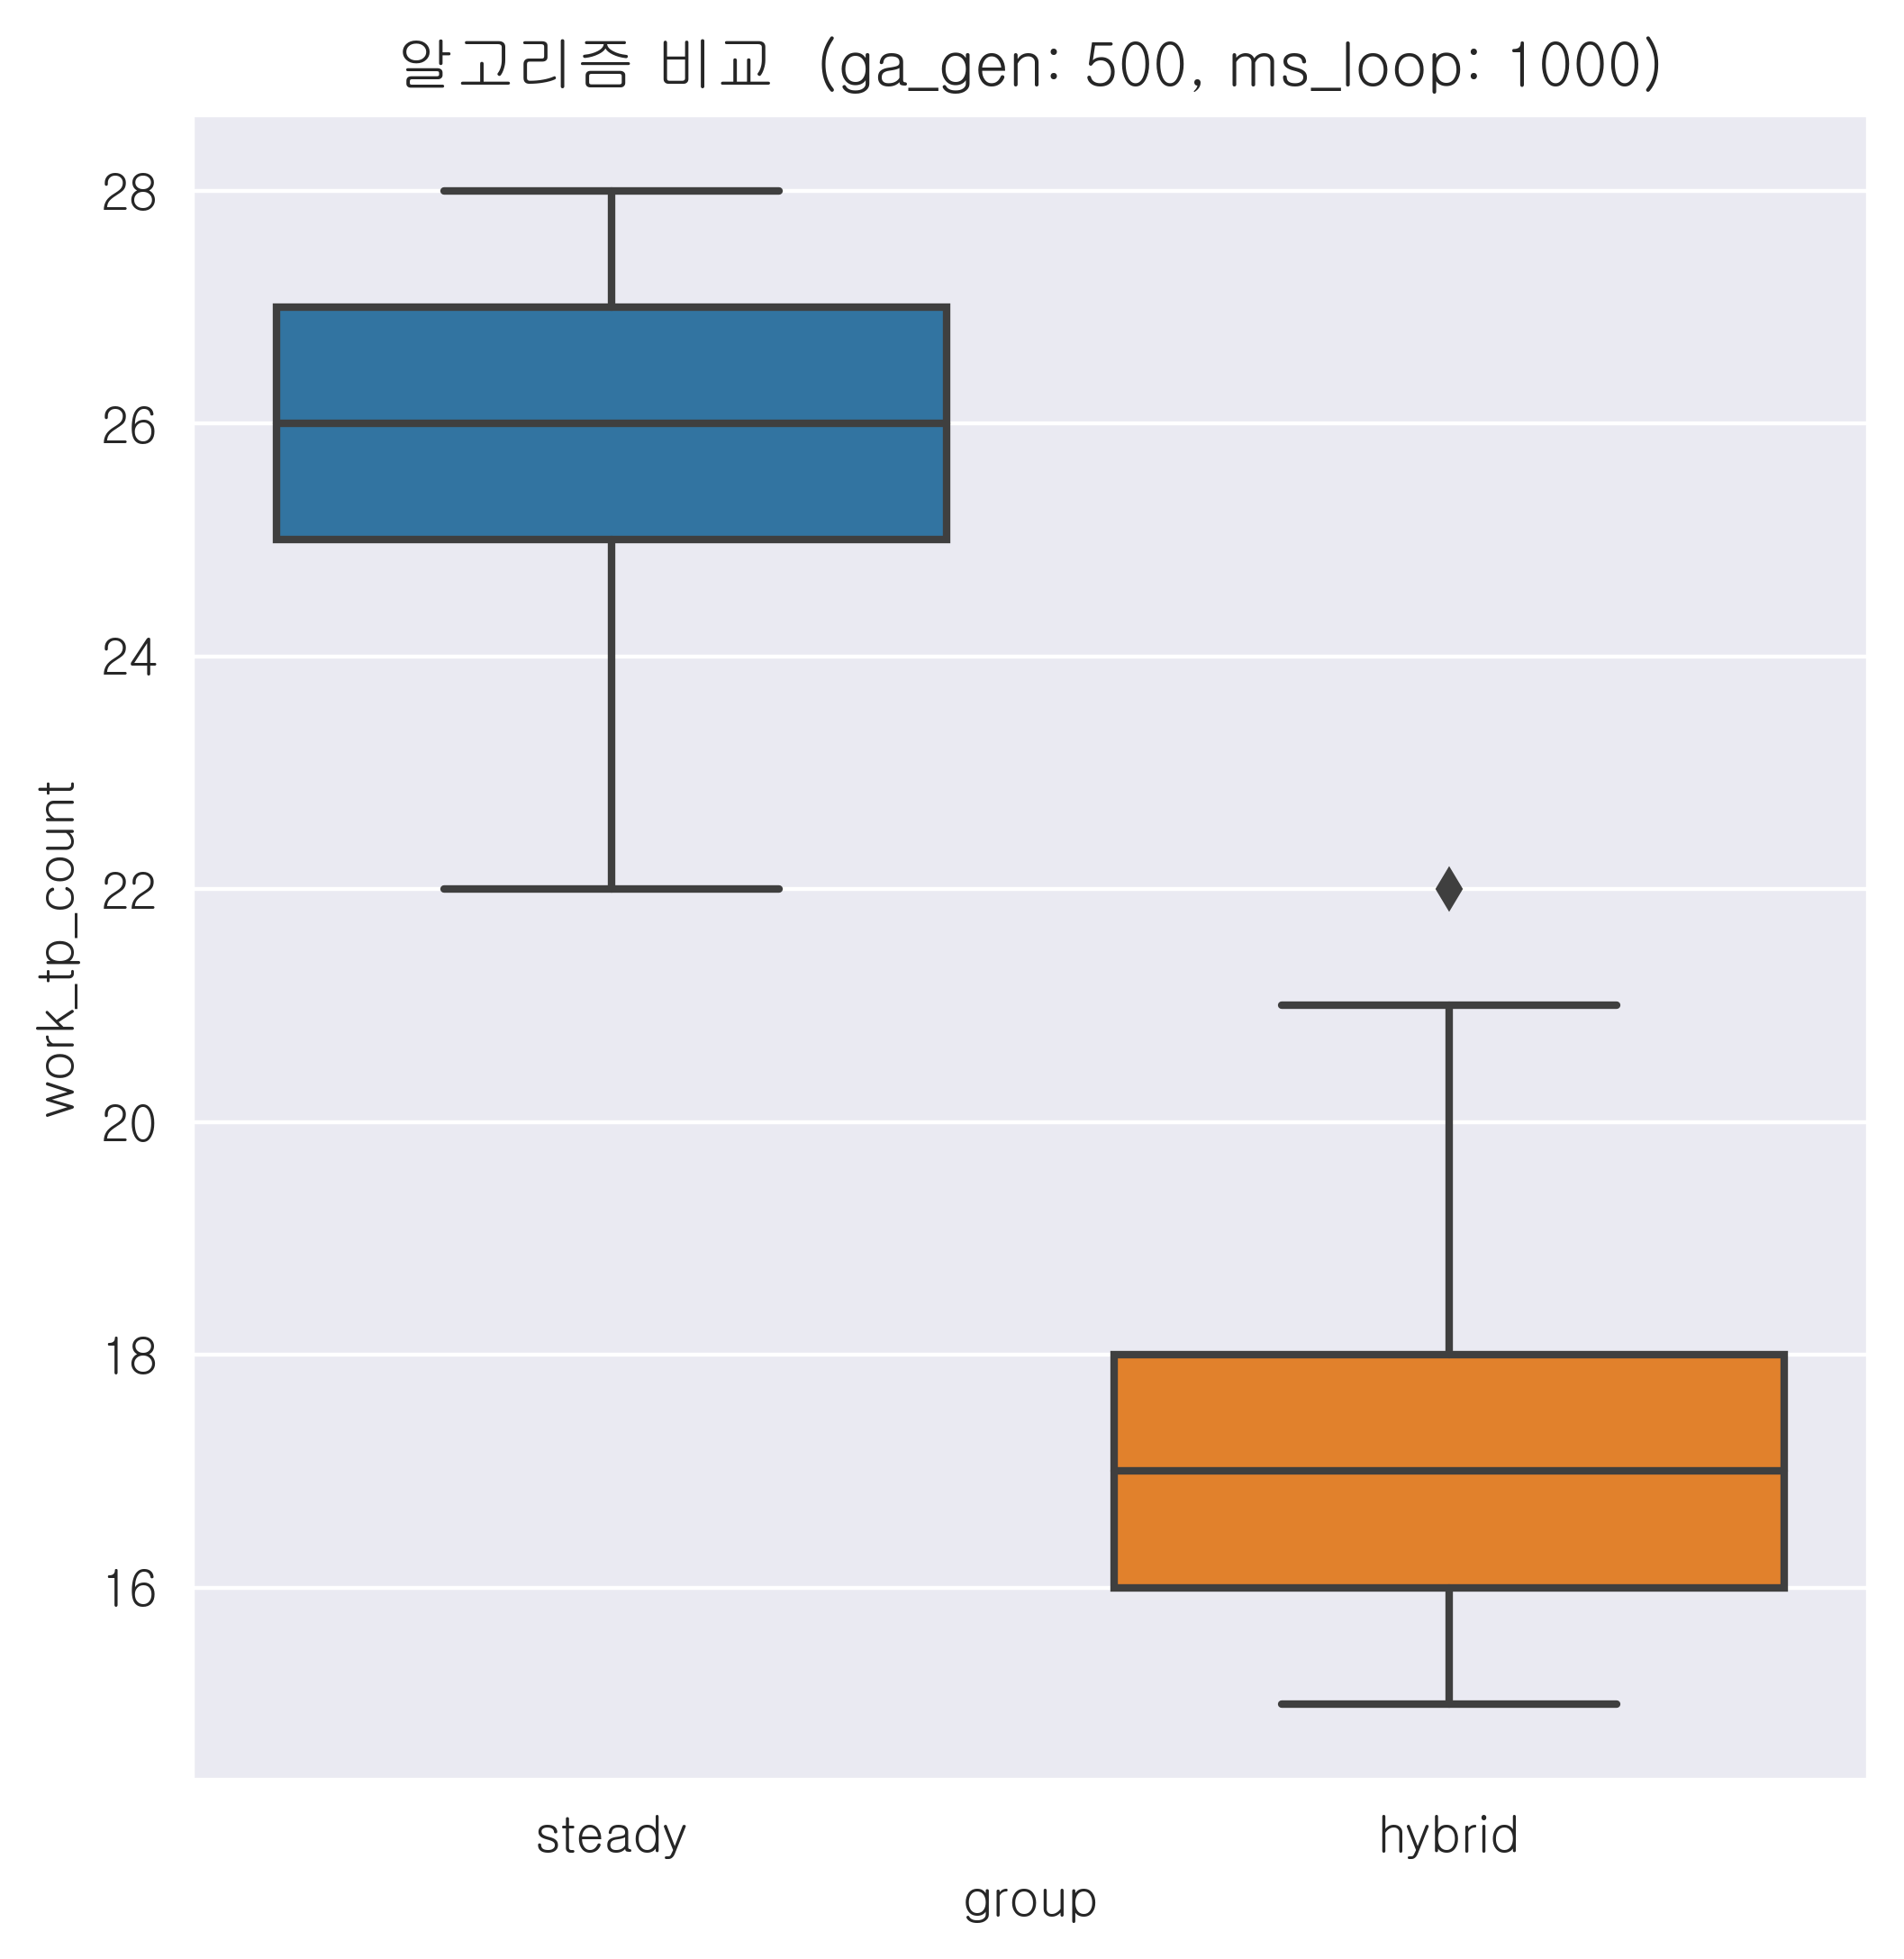

In [61]:
# result4(ga), result5(multistart)
import seaborn as sns
plt.figure(figsize=(6, 6), dpi=400)
sns.boxplot(x='group', y='work_tp_count', data=concatenated_df)
plt.title('알고리즘 비교  (ga_gen: 500, ms_loop: 1000)')

# 각 그룹의 최고점과 최저점을 계산합니다.
groups = concatenated_df.groupby('group')['work_tp_count']
min_points = round(groups.min(),3)
max_points = round(groups.max(), 3)

plt.show()


In [9]:
import matplotlib.pyplot as plt

# 2차원 리스트 생성 (3x3)
data = result['similarity']
# data = [sorted(row, reverse=True) for row in data]
# 리스트의 크기 (row, col) 설정
num_rows = len(data)
num_cols = len(data[0])

# x축, y축 값 생성
x_values = list(range(num_cols))
y_values = list(range(num_rows))

# 그래프 크기 설정
plt.figure(figsize=(18, 13))

# 그래프 그리기
for i in range(num_rows):
    for j in range(num_cols):
        plt.plot(i, data[i][j], 'o', linewidth=2, markersize=2, alpha=0.8)



# 그래프 제목 설정
plt.title('2D List Plot', fontsize=16)

# 범례 표시
plt.legend(loc='upper left', fontsize=14)

# 그래프 표시
plt.show()


KeyError: 'similarity'

In [10]:
data3 = result3['similarity'] # mutation rate 1
data2 = result2['similarity'] # mutaiuon rate 0.05
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].plot(range(len(data3)), data3)
axs[0].set_ylim([7, 25])
axs[0].set_title("mutation_rate: 1",  fontsize=16)


axs[1].plot(range(len(data2)), data2)
axs[1].set_ylim([7, 25])
axs[1].set_title("mutation_rate: 0.05",  fontsize=16)

# 유사도가 작을 수록 변이가 높다
plt.show()

NameError: name 'result3' is not defined